# Sentiment Analysis

In this notebook, we will investigate the sentiment visible in politicians' tweets. We will perform two methods: a lexicon-based approach using VADER [1] and a supervised approach using the most recent version of the RoBERTa-base model [2].

TODO:

- more comments
- conclusion


## 1. Libraries

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tqdm
import torch

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from wordcloud import WordCloud


## 2. Reading data

In [2]:
df = pd.read_parquet('cleaned_data/df_combined.parquet')
nltk.download('vader_lexicon')
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\CarpeDiem\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,in_reply_to_user_id,reply_settings,author_id,context_annotations,id,text,edit_controls,referenced_tweets,created_at,edit_history_tweet_ids,...,links,hashtags,retweet_count,reply_count,like_count,quote_count,impression_count,text_clean_en,text_clean_en_demojized,name
0,375146901.0,everyone,1.182212e+09,[{'domain': {'description': 'Named people in t...,1846277256509116672,"@donaldtusk Niezrealizowanie większości ze ""10...",{'editable_until': '2024-10-15 20:49:34+00:00'...,"[{'id': '1846091776269963695', 'type': 'replie...",2024-10-15 19:49:34+00:00,[1846277256509116623],...,[],[],3,1,33,0,1555,"Failure to implement most of the ""100 specifi...","Failure to implement most of the ""100 specifi...",Bartłomiej Pejo
1,NaN,everyone,1.182212e+09,[{'domain': {'description': 'Named people in t...,1846222583898784000,Rok po wyborach trzeba powiedzieć jedno - nie ...,{'editable_until': '2024-10-15 17:12:19+00:00'...,None,2024-10-15 16:12:19+00:00,[1846222583898784025],...,[https://t.co/4Jh5Ni6sgr],[],9,2,72,0,3031,"A year after the elections, one thing must be ...","A year after the elections, one thing must be ...",Bartłomiej Pejo
2,NaN,everyone,1.182212e+09,None,1846161400328028160,"❌ Mamy rok po wyborach, a Polska pogrąża się ...",{'editable_until': '2024-10-15 13:09:12+00:00'...,None,2024-10-15 12:09:12+00:00,[1846161400328028272],...,"[https://t.co/zFk5QLd1em, https://t.co/bRV4y07...",[],4,3,33,2,8636,"❌ We are a year after the elections, and Pola...",:cross_mark: We are a year after the election...,Bartłomiej Pejo
3,NaN,everyone,1.182212e+09,None,1846091824101769472,Mija rok od wyborów parlamentarnych. W kampani...,{'editable_until': '2024-10-15 08:32:44+00:00'...,None,2024-10-15 07:32:44+00:00,[1846091824101769490],...,"[https://t.co/rtVu3Bh43G, https://t.co/8Q3LME6...",[],6,2,38,0,2441,A year has passed since the parliamentary elec...,A year has passed since the parliamentary elec...,Bartłomiej Pejo
4,NaN,everyone,1.182212e+09,None,1846075343188144128,#Idę11 🇵 🇱 https://t.co/KiCe5ATOpX,{'editable_until': '2024-10-15 07:27:14+00:00'...,None,2024-10-15 06:27:14+00:00,[1846075343188144153],...,[https://t.co/KiCe5ATOpX],[#Idę11],45,18,616,2,8634,#I'm going11 🇵 🇱,#I'm going11 🇵 🇱,Bartłomiej Pejo


## 3. Additional cleaning data

In [9]:
na_count = df['text_clean_en'].isna().sum()
print(f"Number of NaN values in 'text_clean_en': {na_count}. Total number of rows: {len(df)}")

Number of NaN values in 'text_clean_en': 204. Total number of rows: 11457


In [22]:
df_no_na = df[df['text_clean_en'].notna()]

To perform sentiment analysis on tweet texts, we filtered out all tweets without any text. There were 204 such tweets, leaving us with 11,253 tweets after filtering.

## 4. Lexicon based Sentiment Analysis (VADER)

In [25]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm.tqdm(df_no_na.iterrows(), total=len(df_no_na)):
    text = row['text_clean_en_demojized']
    myID = row['id']
    res[myID] = sia.polarity_scores(text)

vader_res = pd.DataFrame.from_dict(res, orient='index').reset_index()
vader_res.rename(columns={'index': 'id', 'neg': 'neg_vader', 'neu': 'neu_vader', 'pos': 'pos_vader', 'compound': 'compound_vader'}, inplace=True)
print("Average sentiment scores:")
print(vader_res.iloc[:, 1:5].mean())
df_no_na = df_no_na.merge(vader_res, on='id', how='left')
df_no_na[["username", "name", "text_clean_en", "neg_vader", "neu_vader", "pos_vader", "compound_vader"]].head()

  0%|          | 0/11253 [00:00<?, ?it/s]

100%|██████████| 11253/11253 [00:08<00:00, 1344.67it/s]

Average sentiment scores:
neg_vader         0.068163
neu_vader         0.781242
pos_vader         0.150505
compound_vader    0.166236
dtype: float64


,username,name,text_clean_en,neg_vader,neu_vader,pos_vader,compound_vader
0,bartlomiejpejo,Bartłomiej Pejo,"Failure to implement most of the ""100 specifi...",0.106,0.851,0.043,-0.5574
1,bartlomiejpejo,Bartłomiej Pejo,"A year after the elections, one thing must be ...",0.000,0.883,0.117,0.3382
2,bartlomiejpejo,Bartłomiej Pejo,"❌ We are a year after the elections, and Pola...",0.075,0.838,0.087,-0.0772
3,bartlomiejpejo,Bartłomiej Pejo,A year has passed since the parliamentary elec...,0.165,0.693,0.142,-0.3612
4,bartlomiejpejo,Bartłomiej Pejo,#I'm going11 🇵 🇱,0.000,1.000,0.000,0.0000


### 4.1. Top 5 most negative politicians

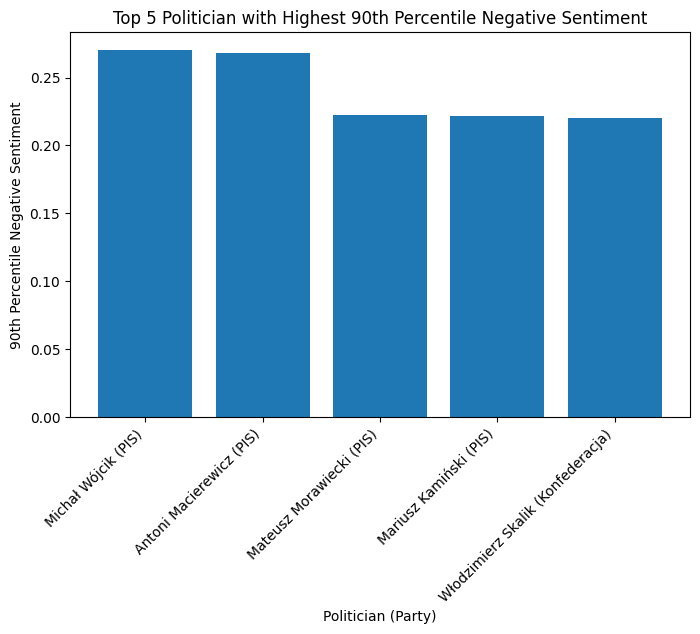

In [46]:
percentile_90_neg = df_no_na.groupby('username')['neg_vader'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='neg_vader', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

According to VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets include 4 individuals from PIS and 1 from Konfederacja.

### 4.2. Top 5 most positive politicians

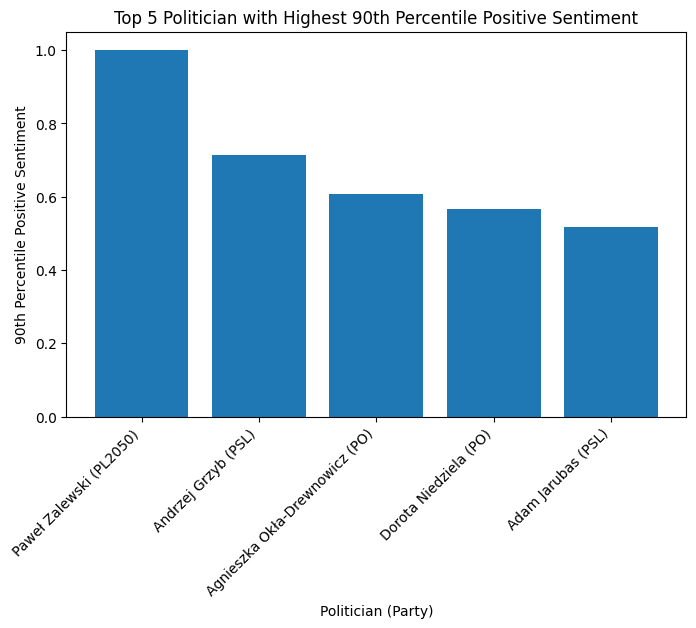

In [47]:
percentile_90_pos = df_no_na.groupby('username')['pos_vader'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='pos_vader', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of positive sentiment in their tweets include 2 individuals from PO, 2 from PSL, and 1 from PL2050.

### 4.3. Negative Sentiment on party level

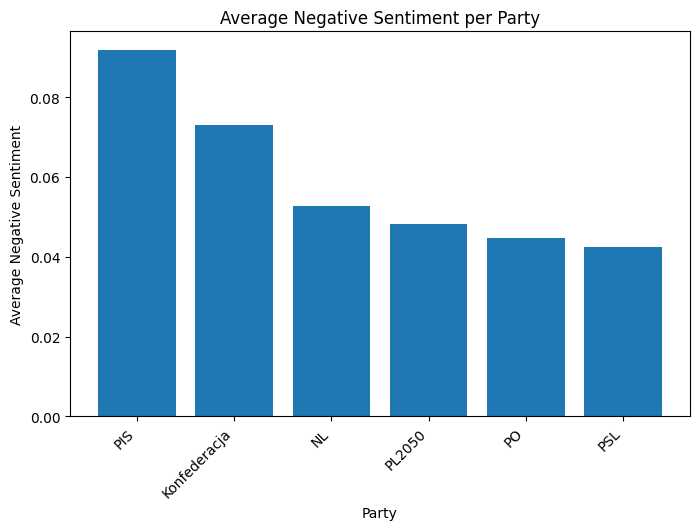

In [53]:
average_neg_sentiment_party = df_no_na.groupby('party')['neg_vader'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='neg_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the plot shows the highest average negative sentiment for PIS, followed closely by Konfederacja. The lowest average negative sentiment is observed for PO and PSL.

### 4.4. Positive Sentiment on party level

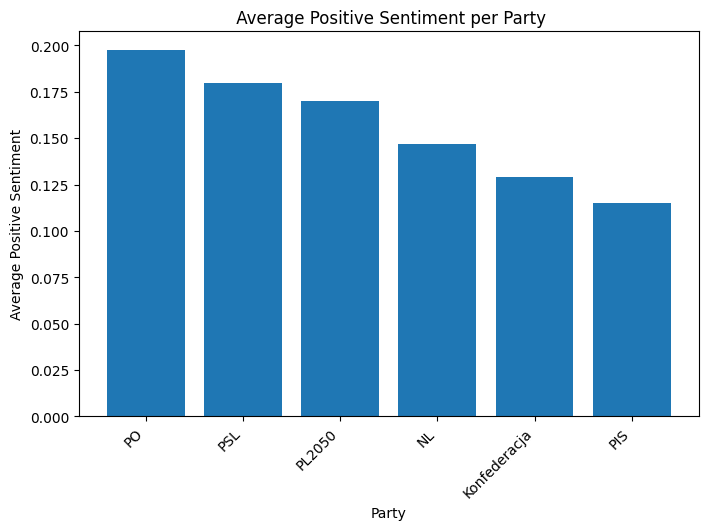

In [79]:
average_pos_sentiment_party = df_no_na.groupby('party')['pos_vader'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='pos_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


We can observe that the plot is a rotated version of the previous plot. The highest average positive sentiment is for PL2050, PO, and PSL, while NL, Konfederacja, and PIS have lower scores.

### 4.5. Most Negative Tweets 

In [57]:
top_5_negative_tweets = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                     name         party               text_clean_en  neg_vader
2759    Witold Tumanowicz  Konfederacja                         NO.      1.000
2764    Witold Tumanowicz  Konfederacja                         NO.      1.000
5245   Mateusz Morawiecki           PIS               Embarrassing.      1.000
6195        Michał Wójcik           PIS                    Shocking      1.000
8945    Izabela Leszczyna            PO                          NO      1.000
10035      Paweł Zalewski        PL2050                    Horrible      1.000
10691        Adam Jarubas           PSL                    Nonsense      1.000
11147   Urszula Pasławska           PSL               Unfortunately      1.000
8173     Dorota Niedziela            PO  Shamelessness and villainy      0.857
2304   Włodzimierz Skalik  Konfederacja            Stupid question.      0.773


In [69]:
pd.set_option('display.max_colwidth', None)
df_no_na['word_count'] = df_no_na['text_clean_en'].apply(lambda x: len(str(x).split()))
df_no_na = df_no_na[df_no_na['word_count'] >= 3]
top_negative_posts = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets (longer than 2 words):")
print(top_negative_posts)

Top 5 Most Negative Tweets (longer than 2 words):
                    name         party  \
8173    Dorota Niedziela            PO   
5559  Mateusz Morawiecki           PIS   
8110    Dorota Niedziela            PO   
3023   Witold Tumanowicz  Konfederacja   
6107       Michał Wójcik           PIS   
5652  Mateusz Morawiecki           PIS   
6744         Patryk Jaki           PIS   
5069  Antoni Macierewicz           PIS   
2441  Włodzimierz Skalik  Konfederacja   
2664  Włodzimierz Skalik  Konfederacja   

                                                      text_clean_en  neg_vader  
8173                                     Shamelessness and villainy      0.857  
5559                                                  What a shame.      0.756  
8110           Search No. 2, The world of hatred, lies and villainy      0.681  
3023                               The Internet takes no prisoners!      0.659  
6107                           \n\nNasty government with no future.      0.659  
5

We observed that VADER was able to capture negative tweets; however, they were not as negative as expected. Without filtering the shortest tweets, the most negative tweets were simply "NO." After filtering to consider tweets longer than two words, the tweets were still not very negative or offensive.

### 4.6. Most Positive Tweets 

In [90]:
top_5_positive_tweets = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                            name         party  \
1532            Sławomir Mentzen  Konfederacja   
1168            Sławomir Mentzen  Konfederacja   
9770        Katarzyna Pelczyńska        PL2050   
2707          Włodzimierz Skalik  Konfederacja   
10551               Adam Jarubas           PSL   
8266            Dorota Niedziela            PO   
9513   Agnieszka Okła-Drewnowicz            PO   
10415              Andrzej Grzyb           PSL   
9488   Agnieszka Okła-Drewnowicz            PO   
4366                Beata Szydło           PIS   

                              text_clean_en  pos_vader  
1532            Congratulations! Good luck!      1.000  
1168         Congratulations and good luck!      0.910  
9770   Freedom, tolerance, mutual respect.       0.905  
2707             God, thanks and greetings!      0.890  
10551       We strengthen security. Respect      0.886  
8266                     Happy Hallelujah 🐣      0.885  
9513                  

In [92]:
pd.set_option('display.max_colwidth', None)
df_no_na['word_count'] = df_no_na['text_clean_en'].apply(lambda x: len(str(x).split()))
df_no_na = df_no_na[df_no_na['word_count'] >= 5]
top_positive_posts = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets (longer than 5 words):")
print(top_positive_posts)

Top 5 Most Positive Tweets (longer than 5 words):
                            name         party  \
5378          Mateusz Morawiecki           PIS   
9039   Małgorzata Kidawa-Błońska            PO   
8222            Dorota Niedziela            PO   
2385          Włodzimierz Skalik  Konfederacja   
10231           Dariusz Klimczak           PSL   
1122            Sławomir Mentzen  Konfederacja   
2911           Witold Tumanowicz  Konfederacja   
5383          Mateusz Morawiecki           PIS   
6002               Michał Wójcik           PIS   
6084               Michał Wójcik           PIS   

                                                           text_clean_en  \
5378                               Congratulations and good luck!  🇵 🇱 🚀   
9039                                     Beautiful 🇵 🇱 🇪 🇺 #Wiec4Czerwca   
8222          Celebrating 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱 #DzieńaflagiRP 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱   
2385                                     He who laughs last laughs best.   
10231              

### 4.7. Wordclouds

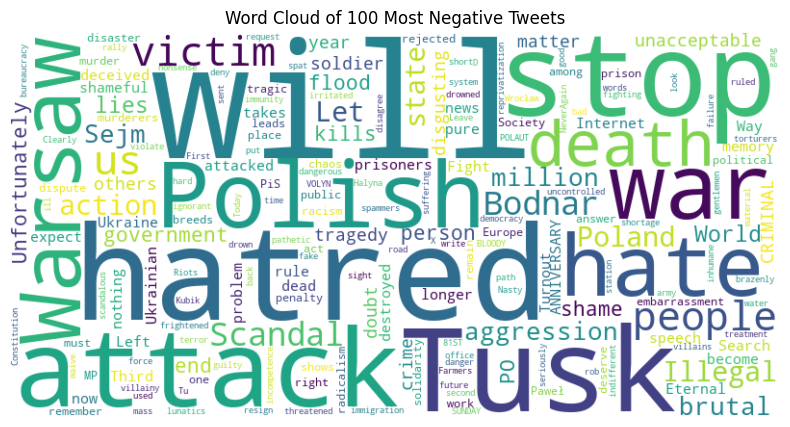

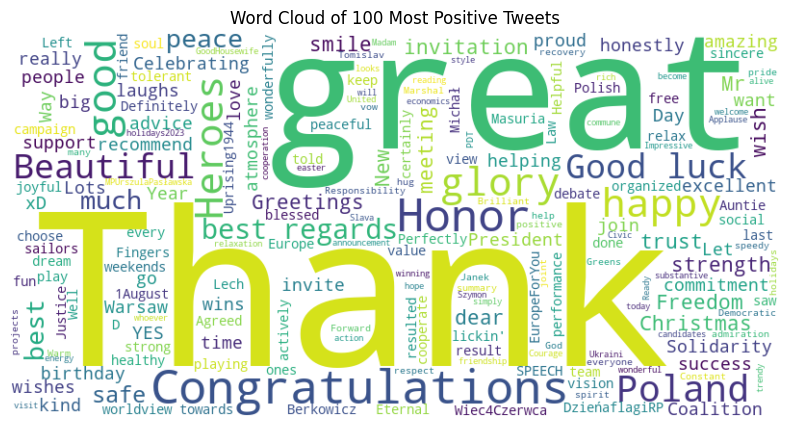

In [95]:
top_negative_posts = df_no_na.nlargest(100, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_no_na.nlargest(100, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 5. Supervised approach Sentiment Analysis (BERT)

In [83]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def bert_predict(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].cpu().numpy()
    scores = softmax(scores)
    return scores

df_no_na['text_bert'] = df_no_na['text_clean_en_demojized'].apply(preprocess)
df_no_na[['negative_bert', 'neutral_bert', 'positive_bert']] = df_no_na['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))
df_no_na[["username", "name", "text_clean_en", "negative_bert", "neutral_bert", "positive_bert"]].head()

C:\Users\CarpeDiem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\CarpeDiem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Thi

,username,name,text_clean_en,negative_bert,neutral_bert,positive_bert
0,bartlomiejpejo,Bartłomiej Pejo,"Failure to implement most of the ""100 specifics"", instead of transparency a ""furniture store"" when appointing the Social Security Service, instead of a cheap state, a record deficit and the most numerous government in history, and instead of the rule of law, a police state. This is a picture of your government a year after the elections.",0.850091,0.139991,0.009918
1,bartlomiejpejo,Bartłomiej Pejo,"A year after the elections, one thing must be said - this is not the country Donald Tusk agreed with voters!",0.755525,0.230793,0.013682
2,bartlomiejpejo,Bartłomiej Pejo,"❌ We are a year after the elections, and Poland is sinking into crisis and anarchy. \n\nOf the promised 100 specific items, Donald Tusk's government implemented only about 30. For example, such demands as: an increase in the tax-free amount, the introduction of a system of medical visits via SMS and...",0.786622,0.204867,0.008511
3,bartlomiejpejo,Bartłomiej Pejo,"A year has passed since the parliamentary elections. Many promises were made by the government during the election campaign. What do we get from it today? In smiling Poland we have chaos in the justice system, financial gridlock in the health service and a record deficit. Donald Tusk's rule is a disaster for...",0.817513,0.169303,0.013184
4,bartlomiejpejo,Bartłomiej Pejo,#I'm going11 🇵 🇱,0.044821,0.769139,0.186040


### 5.1. Top 5 most negative politicians

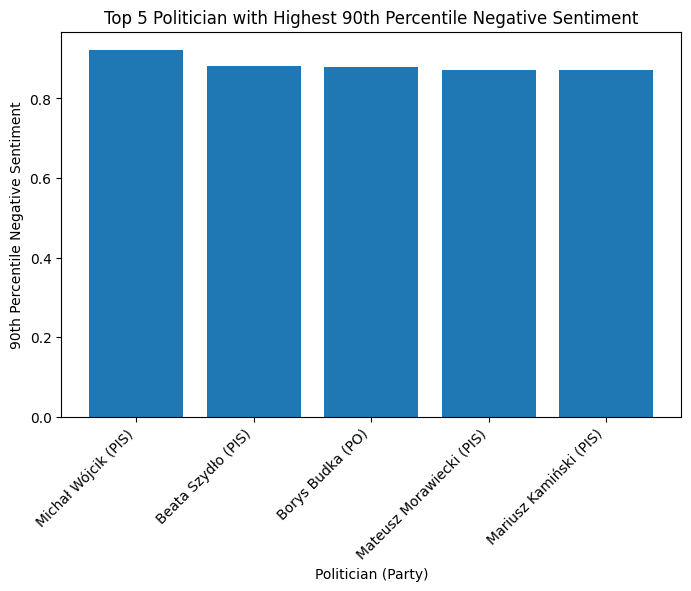

In [80]:
percentile_90_neg = df_no_na.groupby('username')['negative_bert'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='negative_bert', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

### 5.2. Top 5 most positive politicians

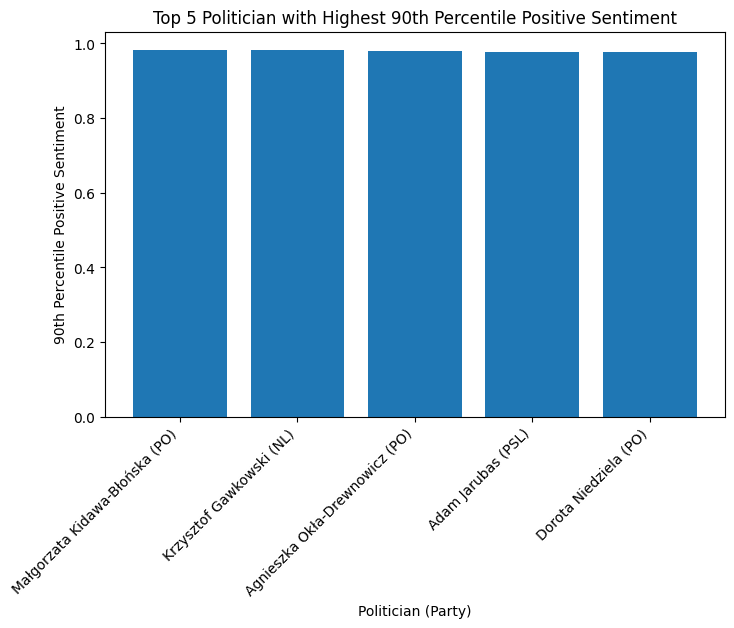

In [81]:
percentile_90_pos = df_no_na.groupby('username')['positive_bert'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='positive_bert', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

### 5.3. Negative Sentiment on party level

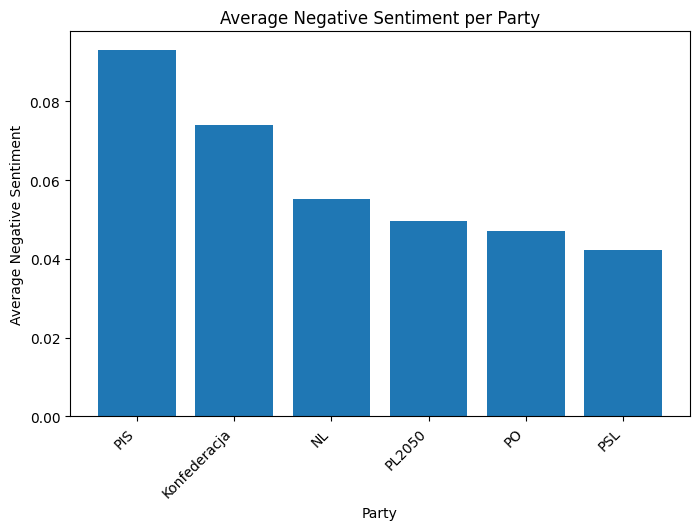

In [84]:
average_neg_sentiment_party = df_no_na.groupby('party')['neg_vader'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='neg_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


### 5.4. Positive Sentiment on party level

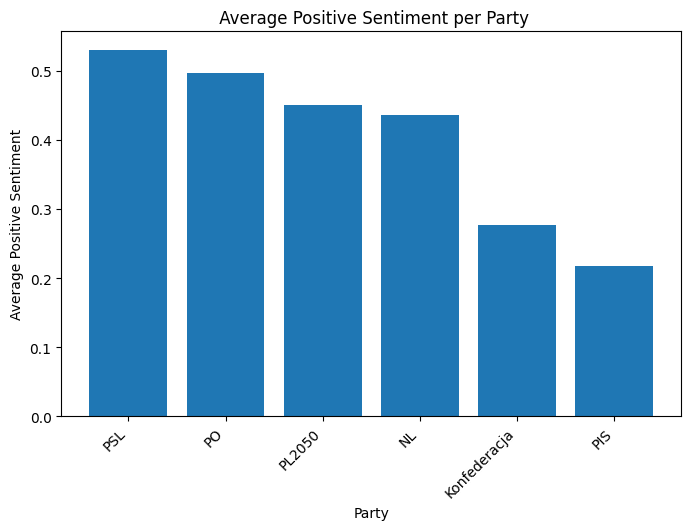

In [82]:
average_pos_sentiment_party = df_no_na.groupby('party')['positive_bert'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='positive_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


### 5.5. Most Negative Tweets 

In [86]:
top_5_negative_tweets = df_no_na.nlargest(10, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                     name         party  \
5874        Michał Wójcik           PIS   
1009     Sławomir Mentzen  Konfederacja   
5974        Michał Wójcik           PIS   
1867   Włodzimierz Skalik  Konfederacja   
4858     Mariusz Kamiński           PIS   
6639          Patryk Jaki           PIS   
6886          Patryk Jaki           PIS   
6109        Michał Wójcik           PIS   
4874     Mariusz Kamiński           PIS   
3639  Krzysztof Gawkowski            NL   

                                                                                                                                                                                                                                                                       text_clean_en  \
5874                                                                                                                                        The economy is sinking, the judiciary is sinking, and Polish science is also s

### 5.6. Most Positive Tweets 

In [89]:
top_5_positive_tweets = df_no_na.nlargest(10, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                            name         party  \
8429                  Ewa Kopacz            PO   
11084  Władysław Kosiniak-Kamysz           PSL   
1033            Sławomir Mentzen  Konfederacja   
4019              Robert Biedroń            NL   
3633         Krzysztof Gawkowski            NL   
1023            Sławomir Mentzen  Konfederacja   
5434          Mateusz Morawiecki           PIS   
7634                 Borys Budka            PO   
9698        Katarzyna Pelczyńska        PL2050   
9066   Małgorzata Kidawa-Błońska            PO   

                                                                                                                                                        text_clean_en  \
8429                                                   A beautiful day and great hope that the dreams of many Polish families will come true. I am extremely touched!   
11084                                                                              

### 5.7. Wordclouds

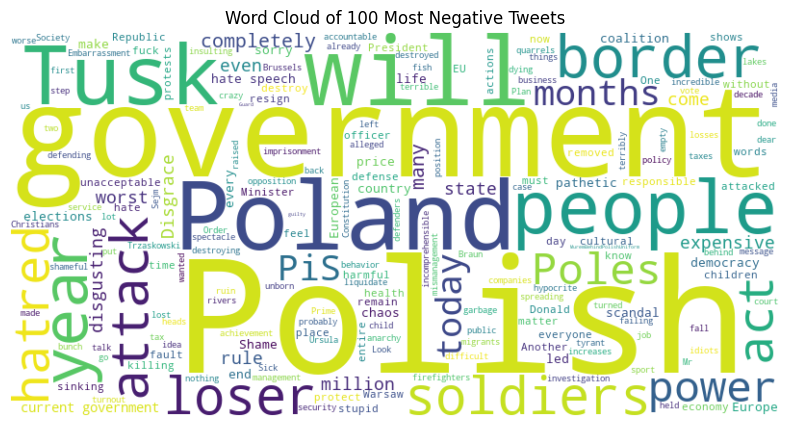

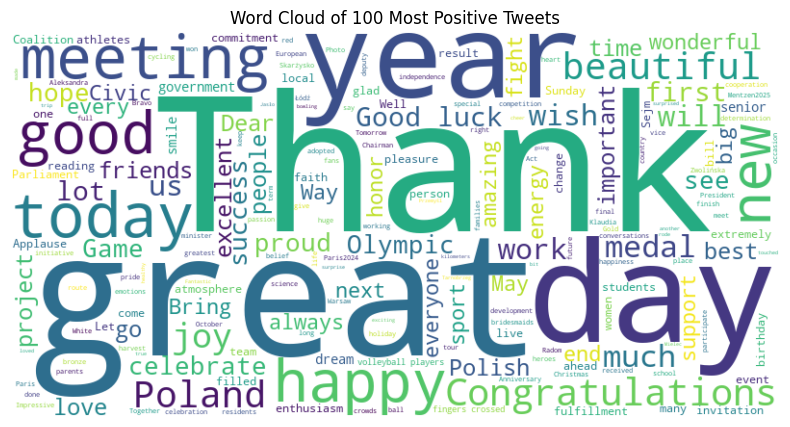

In [96]:
top_negative_posts = df_no_na.nlargest(100, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_no_na.nlargest(100, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 6. Conclusions

## 7. Refrences

[1] Hutto, C., & Gilbert, E. (2014). VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. Proceedings of the International AAAI Conference on Web and Social Media, 8(1), 216–225. https://doi.org/10.1609/icwsm.v8i1.14550

[2] Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, and Veselin Stoyanov. 2019. Roberta: A robustly optimized bert pretraining approach. arXiv preprint arXiv:190711692.
